In [1]:
from __future__ import print_function

import csv
import os
import math 

import numpy as np

import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import random

import models

from tqdm import tqdm_notebook as tqdm


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

from advertorch.attacks import CarliniWagnerL2Attack

In [2]:
args = {
    'model': 'ResNet18',
    'data': 'cifar10',
    'nclass': 10,
    'lr': 0.1,
    'batch_size': 128,
    'epoch': 50,
    'augment': False,
    'decay': 1e-4,
    'name': 'cross',
    'seed': 0,
    'resume': False,
    'klam': 4,
    'mode': 'perturb',
    'upper': 0.65,
}

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
criterion = nn.CrossEntropyLoss()
best_acc = 0  # best test accuracy
if args['seed'] != 0:
    torch.manual_seed(args['seed'])
    np.random.seed(args['seed'])

## Functions

In [45]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def label_to_onehot(target, num_classes=args['nclass']):
    '''Returns one-hot embeddings of scaler labels'''
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(
        0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target


def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))


def mixup_criterion(pred, ys, lam_batch, num_class=args['nclass']):
    '''Returns mixup loss'''
    ys_onehot = [label_to_onehot(y, num_classes=num_class) for y in ys]
    mixy = vec_mul_ten(lam_batch[:, 0], ys_onehot[0])
    for i in range(1, args['klam']):
        mixy += vec_mul_ten(lam_batch[:, i], ys_onehot[i])
    l = cross_entropy_for_onehot(pred, mixy)
    return l


def vec_mul_ten(vec, tensor):
    '''
        
    '''
    size = list(tensor.size())
    size[0] = -1
    size_rs = [1 for i in range(len(size))]
    size_rs[0] = -1
    vec = vec.reshape(size_rs).expand(size)
    res = vec * tensor
    return res


def mixup_data(x, y, use_cuda=True, perturbed_examples=None, perturb_labl=None):
    '''Returns mixed inputs, lists of targets, and lambdas'''
    lams = np.random.normal(0, 1, size=(x.size()[0], args['klam']))
    for i in range(x.size()[0]):
        lams[i] = np.abs(lams[i]) / np.sum(np.abs(lams[i]))
        if args['klam'] > 1:
            while lams[i].max() > args['upper']:     # upper bounds a single lambda (or (lams[i][0] + lams[i][1]) < args['dom'])
                lams[i] = np.random.normal(0, 1, size=(1, args['klam']))
                lams[i] = np.abs(lams[i]) / np.sum(np.abs(lams[i]))

    lams = torch.from_numpy(lams).float().to(device)

    mixed_x = vec_mul_ten(lams[:, 0], x)
    ys = [y]
    
    if args['mode'] == 'perturb':
        for i in range(0, math.ceil(args['klam']/2)):
            batch_size = perturbed_examples.size()[0]
            index = torch.randperm(batch_size).to(device)
            mixed_x += vec_mul_ten(lams[:, i], perturbed_examples[index, :])
            ys.append(perturb_labl[index])
        for i in range(math.ceil(args['klam']/2), args['klam']):
            batch_size = x.size()[0]
            index = torch.randperm(batch_size).to(device)
            mixed_x  += vec_mul_ten(lams[:, i], x[index, :])
            ys.append(y[index])
        
    else:
        for i in range(1, args['klam']):
            batch_size = x.size()[0]
            index = torch.randperm(batch_size).to(device)
            mixed_x  += vec_mul_ten(lams[:, i], x[index, :])
            ys.append(y[index])         # Only keep the labels for private samples

    if args['mode'] == 'instahide': # TODO -> from adding random flip mask, 
        sign = torch.randint(2, size=list(x.shape), device=device) * 2.0 - 1
        mixed_x *= sign.float().to(device)
    return mixed_x, ys, lams


def generate_sample(trainloader):
    assert len(trainloader) == 1        # Load all training data once
    
    if args['mode'] == 'perturb':
        perturbed_examples = np.load('results/perturbed.npy')
        perturbed_lables = np.load('results/perturbed_y.npy')
    
    for _, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.to(device), targets.to(device)
            if args['mode'] == 'perturb':
                perturbed_examples, perturbed_lables = torch.Tensor(perturbed_examples).to(device), torch.Tensor(perturbed_lables).to(device)
        if args['mode'] == 'perturb':
            mix_inputs, mix_targets, lams = mixup_data(
                inputs, targets.float(), use_cuda, perturbed_examples, perturbed_lables)
        else:
            mix_inputs, mix_targets, lams = mixup_data(
                inputs, targets.float(), use_cuda)
    return (mix_inputs, mix_targets, inputs, targets, lams)

def prepare_data():
    ## --------------- Prepare data --------------- ##
    print('==> Preparing data..')

    cifar_normalize = transforms.Normalize(
        (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    
    mnist_normalize = transforms.Normalize((0.1307,), (0.3081,))

    transform_imagenet = transforms.Compose([
        transforms.Resize(40),
        transforms.RandomCrop(32),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

    if args['augment']:
        transform_cifar_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            cifar_normalize
        ])
        
        transform_mnist_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            mnist_normalize
        ])
    else:
        transform_cifar_train = transforms.Compose([
            transforms.ToTensor(),
            cifar_normalize
        ])
        
        transform_mnist_train = transforms.Compose([
            transforms.ToTensor(),
            mnist_normalize
        ])

    transform_cifar_test = transforms.Compose([
        transforms.ToTensor(),
        cifar_normalize
    ])
    
    transform_mnist_test = transforms.Compose([
        transforms.ToTensor(),
        mnist_normalize
    ])

    if args['data'] == 'cifar10':
        trainset = datasets.CIFAR10(root='../../Dataset/CIFAR10',
                                    train=True,
                                    download=True,
                                    transform=transform_cifar_train)
        testset = datasets.CIFAR10(root='../../Dataset/CIFAR10',
                                   train=False,
                                   download=True,
                                   transform=transform_cifar_test)
        num_class = 10

    if args['data'] == 'mnist':
        trainset = datasets.MNIST(root='../../Dataset/MNIST', 
                                  train=True, 
                                  download=True, 
                                  transform=transform_mnist_train)

        testset = datasets.MNIST(root='../../Dataset/MNIST',
                               train=False,
                               download=True,
                               transform=transform_mnist_test)
        
    return trainset, testset

def plot_difference(orig, trans, idx=[23, 15], titles=None):
    length = len(trans)
    f, ax = plt.subplots(2, length+1, figsize=(7*(length+1), 14))
    if titles == None:
        titles = [t + 1 for t in range(length)]
        
    for i in range(2):
        ax[i][0].imshow(orig[idx[i]].transpose((1,2,0)))
        for j in range(length):
            ax[i][j+1].imshow(trans[j][idx[i]].transpose((1,2,0)))
        
        if i == 0:
            ax[i][0].set_title('original', fontsize=25)
            for j in range(length):
                ax[i][j+1].set_title(titles[j], fontsize=25)
            
    plt.show()

In [46]:
trainset, testset = prepare_data()
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=len(trainset),
                                          shuffle=False,
                                          num_workers=8)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=args['batch_size'],
                                         shuffle=False,
                                         num_workers=8)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


### Run original mixup instahide

In [47]:
args['mode']='perturb'

In [48]:
mix_inputs_all, mix_targets_all, original_inputs, original_targets, lams = generate_sample(trainloader)
original_inputs_all = original_inputs.detach().cpu().numpy()

In [52]:
args['klam'] = 2
# print('==> Number of lambdas: %g' % args['klam'])
mix_inputs_all, mix_targets_all, original_inputs, original_targets, lams = generate_sample(trainloader)
original_inputs_all = original_inputs.detach().cpu().numpy()
mix_inputs_2 = mix_inputs_all.detach().cpu().numpy()

args['klam'] = 3
mix_inputs_all, mix_targets_all, original_inputs, original_targets, lams = generate_sample(trainloader)
mix_inputs_3 = mix_inputs_all.detach().cpu().numpy()

args['klam'] = 4
mix_inputs_all, mix_targets_all, original_inputs, original_targets, lams = generate_sample(trainloader)
mix_inputs_4 = mix_inputs_all.detach().cpu().numpy()
# mix_targets_all = np.array([det.detach().cpu().numpy() for det in mix_targets_all])
# original_targets_all = np.array([det.detach().cpu().numpy() for det in original_targets_all])

In [ ]:
[9391, 19730]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[38675 42838]


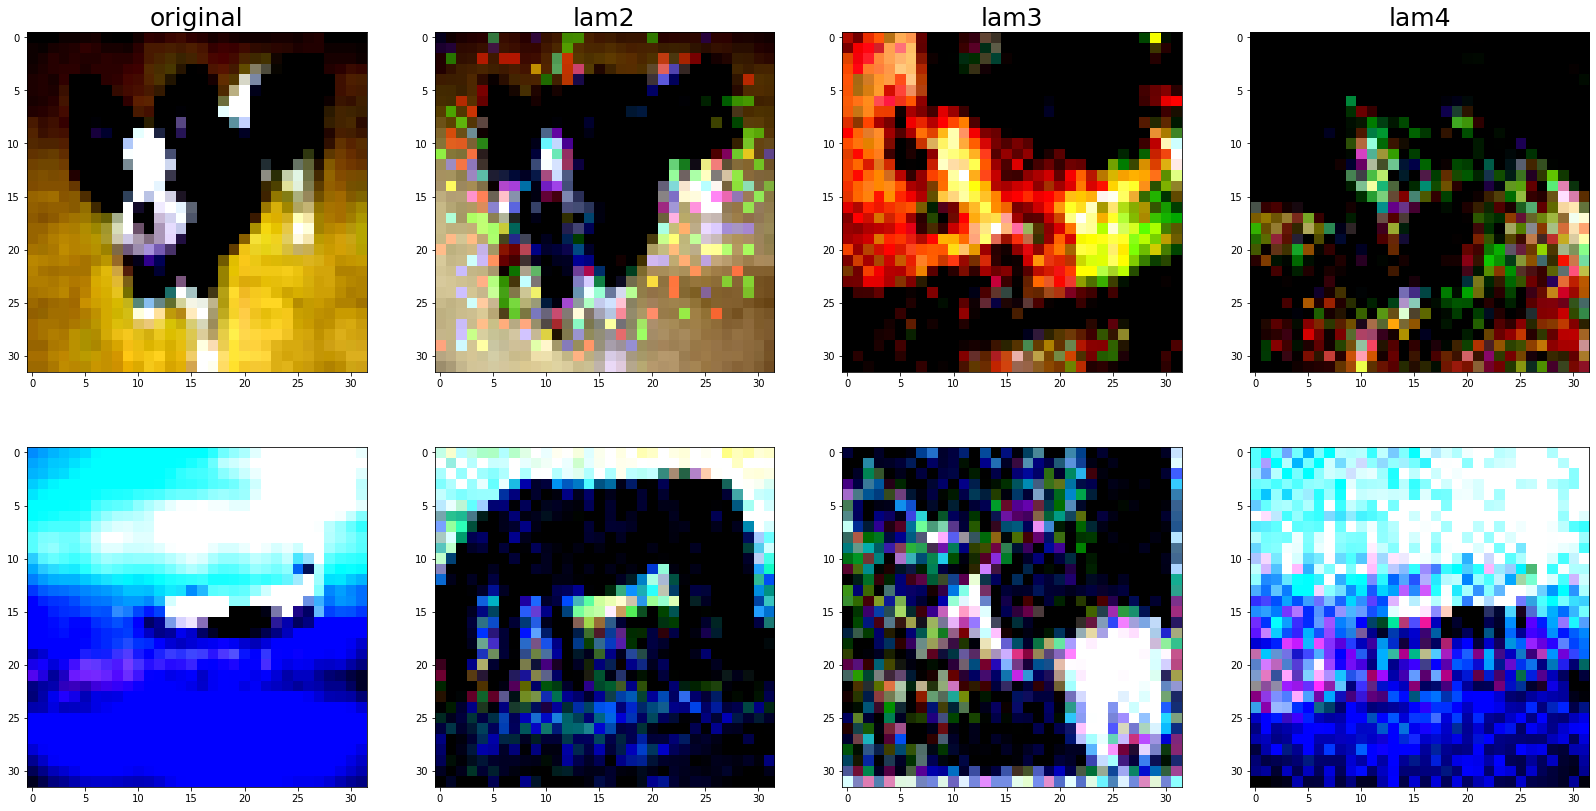

In [53]:
idxs = np.random.randint(0, 49999, 2)
print(idxs)
plot_difference(original_inputs_all, [mix_inputs_2, mix_inputs_3, mix_inputs_4], [ 9391, 19730], titles=['lam2', 'lam3', 'lam4'])

lamb = 1
test = original_inputs_all[idx[i]] - pert[idx[i]]
original = original_inputs_all[idx[i]] + lamb * test
f, ax = plt.subplots(2, 2, figsize=(14,14))
idx = [23, 15]
for i in range(2):
    test = original_inputs_all[idx[i]] - pert[idx[i]]
    original = original_inputs_all[idx[i]] + lamb * test
    ax[i][0].imshow(original_inputs_all[idx[i]].transpose((1,2,0)))
    ax[i][1].imshow(original.transpose((1,2,0)))

# plt.imshow(mix_inputs_all[1].transpose((1,2,0)))


## Instahide keypoint -> random sign function

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


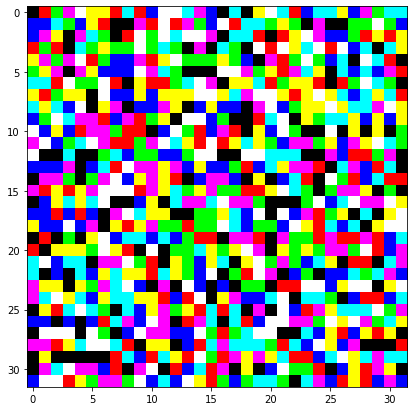

In [10]:
plt.figure(figsize=(7, 7))
sign = torch.randint(2, size=list(original_inputs_all[0].shape), device=device) * 2.0 - 1
plt.imshow(sign.detach().cpu().numpy().transpose( 1,2,0))

In [12]:
original_inputs_ = original_inputs.detach().cpu().numpy()
l2m_inputs_ = np.load('results/perturbed.npy')

In [15]:
l2m_inputs_.shape, original_inputs_.shape

((50000, 3, 32, 32), (50000, 3, 32, 32))

In [39]:
for i in range(6):
    print(int(i/3))

0
0
0
1
1
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


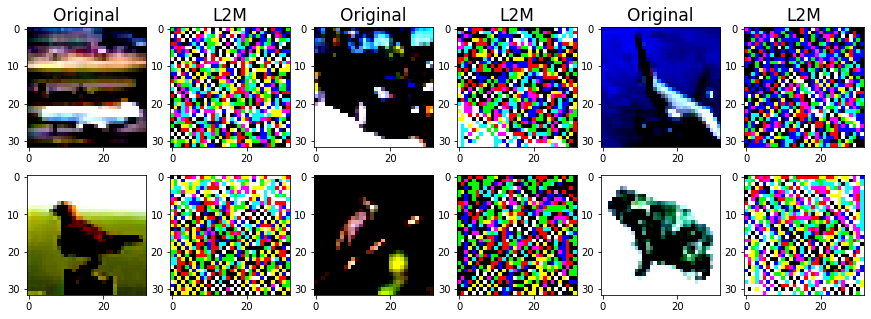

In [42]:
idxs = np.random.randint(0, 49999, 6)

f, ax = plt.subplots(2, 6, figsize=(15, 5))

for i, idx in enumerate(idxs):
    ax[int(i/3)][int(i*2)%6].imshow(original_inputs_[idx].transpose((1,2,0)))
    ax[int(i/3)][int(i*2)%6+1].imshow(l2m_inputs_[idx].transpose((1,2,0)))
    if i < 3:
        ax[int(i/3)][(i*2)%6].set_title('Original', fontsize=17)
        ax[int(i/3)][(i*2)%6+1].set_title('L2M', fontsize=17)
    
    

#     if i == 0:
#         ax[i][0].set_title('original', fontsize=25)
#         for j in range(length):
#             ax[i][j+1].set_title(titles[j], fontsize=25)

plt.show()